In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Create Dataset

In [78]:
def generate_sentence(min_len=0, max_len=20, pos=True):
    if pos:
        n = np.random.randint(np.ceil(min_len / 3), np.ceil((max_len) / 3))
        sentence = n*"a" + n*"b" + n*"c"
        return sentence, len(sentence)
    else:
        n_0 = np.random.randint(0, max_len)
        n_1 = np.random.randint(0, max_len - n_0 + 1)
        n_2 = np.random.randint(min_len - n_0 - n_1, max_len - n_0 - n_1 + 1)
        sentence = n_0 * "a" + n_1 * "b" + n_2 * "c"
        return sentence, len(sentence)

def create_data(size=10000, balance=0.1, min_len=0, max_len=20, train=True):
    data = []
    sentence_lengths = []

    for i in range(int(size*balance)):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        while sentence == "aabbcc" and train:
            sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        if not train:
            sentence, sentence_length = "aabbcc", 6
        data.append((sentence, 1))
        sentence_lengths.append(sentence_length)
    for i in range(int((size - (size*balance)))):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=False)
        data.append((sentence, 0))
        sentence_lengths.append(sentence_length)
    
    random.shuffle(data)
    average_length = sum(sentence_lengths) / len(sentence_lengths)
    return data, average_length

train_data, avg_sent_length_train = create_data(size=1000, balance=0.5, min_len=0, max_len=20, train=True)
val_data, avg_sent_length_val = create_data(size=1000, balance=0.5, min_len=0, max_len=20, train=False)
test_data, avg_sent_length_test = create_data(size=1000, balance=0.5, min_len=21, max_len=100, train=True)

print(f"Train Data Sample:\n{train_data}")
print(f"Average Sentence Length:\n{avg_sent_length_train}")
print(f"Val Data Sample:\n{val_data}")
print(f"Average Sentence Length:\n{avg_sent_length_val}")
print(f"Test Data Sample:\n{test_data}")
print(f"Average Sentence Length:\n{avg_sent_length_test}")


Train Data Sample:
[('aaaaaaaaaaaaaaaabb', 0), ('aaaaaabbbbbbcccccc', 1), ('aaaaabbbbbccccc', 1), ('abbbbbbbccccccccccc', 0), ('aaaaaaabbbbbbbb', 0), ('aaaaaaaabbbccc', 0), ('aaaaaabbbbbbcccccc', 1), ('aaabbbccc', 1), ('aaabbbccc', 1), ('abc', 1), ('aaaaabbbbbccccc', 1), ('abbbbbbbbbbbbbbbccc', 0), ('', 1), ('aaaaaabbbbbbcccccc', 1), ('aaabbbccc', 1), ('aaaaaabbbbbbcccccc', 1), ('aaaaaabbbbbbcccccc', 1), ('aaaaaaaaaaaaabbbc', 0), ('aaabbbccc', 1), ('aaaaaaaaaaaaaaaaabb', 0), ('aaaaabbbbbccccc', 1), ('aaabbbbbbbbbbb', 0), ('aaaaaaaaaaaaaaaaaab', 0), ('abc', 1), ('abc', 1), ('aaaaaaaaaaaaaaaaaab', 0), ('aaaaaaabb', 0), ('aaabbbbbbbbb', 0), ('aaabbbccc', 1), ('abc', 1), ('aaaaabbbbbccccc', 1), ('abc', 1), ('aaaaabbbbbccccc', 1), ('aaaaaaaaaaaaaaaaaa', 0), ('aaaabbbbcccc', 1), ('aaaaaabbbbbbcccccc', 1), ('', 1), ('aaaaaaabbb', 0), ('aaaabbbbcccc', 1), ('aaaaaaaaaaaaabbbbbb', 0), ('abc', 1), ('aaaaaabbbbbbcccccc', 1), ('', 1), ('aaaaabbbbbccccc', 1), ('aaabbbccc', 1), ('aaaabbbbbbbbb', 0), 

In [79]:
# Dependencies
import torch
import torch.nn as nn
import torch.optim as optim

In [80]:
# Encoding data
char_to_index = {'a':[1,0,0], 'b':[0,1,0], 'c':[0,0,1]}
#index_to_char = {v: k for k, v in char_to_index.items()}

def creat_tensors(data, max_l):
    X = []
    y = []
    ml = 0

    for sent, label in data:
        X.append([char_to_index[char] for char in sent])
        y.append(label)

    # Padding to be able to convert to tensor
    X = [sent + [[0,0,0]] * (max_l - len(sent)) for sent in X]

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

X_train, y_train = creat_tensors(train_data, max_l=100)
X_test, y_test = creat_tensors(test_data, max_l=100)
X_val, y_val = creat_tensors(val_data, max_l=100)

In [81]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_val, y_val)
testset = TensorDataset(X_test, y_test)

train_set, val_same_set = torch.utils.data.random_split(train_set, [900, 100])


train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
val_same_loader = DataLoader(val_same_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, BATCH_SIZE, shuffle=True)

## Train and define model

In [82]:
# Set device
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps:0'
else:
    device = 'cpu'
print('GPU State:', device)

GPU State: cpu


In [83]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, hidden_depth) -> None:
        super().__init__()

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, hidden_depth, batch_first=True)
        self.classification= nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        logits = self.classification(output[:,-1,:])
        #print(logits.size())
        return torch.squeeze(logits)

In [96]:
input_size = X_train.shape[2]
hidden_size = 10
hidden_depth = 1
num_epochs = 200
lr=0.001

model = LSTM(input_size, hidden_size, hidden_depth)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        #inputs = inputs.unsqueeze(-1)  # Add input_size dimension
        # Forward pass
        #print(inputs.shape)
        outputs = model(inputs)
        #print(outputs.shape)
        #print(outputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# for param in model.parameters():
#     print(param5

Epoch [10/200], Loss: 0.6937
Epoch [20/200], Loss: 0.6929
Epoch [30/200], Loss: 0.6927
Epoch [40/200], Loss: 0.6932
Epoch [50/200], Loss: 0.6927
Epoch [60/200], Loss: 0.6935
Epoch [70/200], Loss: 0.6933
Epoch [80/200], Loss: 0.6927
Epoch [90/200], Loss: 0.6939
Epoch [100/200], Loss: 0.6931
Epoch [110/200], Loss: 0.6931
Epoch [120/200], Loss: 0.6939
Epoch [130/200], Loss: 0.6926
Epoch [140/200], Loss: 0.6934
Epoch [150/200], Loss: 0.6939
Epoch [160/200], Loss: 0.6933
Epoch [170/200], Loss: 0.6928
Epoch [180/200], Loss: 0.6927
Epoch [190/200], Loss: 0.6931
Epoch [200/200], Loss: 0.6925


In [97]:
from torcheval.metrics import BinaryF1Score

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")

            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            


    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


test_loop(val_loader, model, loss_fn)

Test Error: 
 Accuracy: 50.0%, F1-score: 0.6666666865348816, Avg loss: 0.693524 



In [98]:
test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 50.0%, F1-score: 0.6666666865348816, Avg loss: 0.694829 



In [99]:
test_loop(val_same_loader, model, loss_fn)

Test Error: 
 Accuracy: 46.0%, F1-score: 0.6301369667053223, Avg loss: 0.695775 



Test Error: 
 Accuracy: 50.0%, F1-score: 0.6666666865348816, Avg loss: 0.694451 



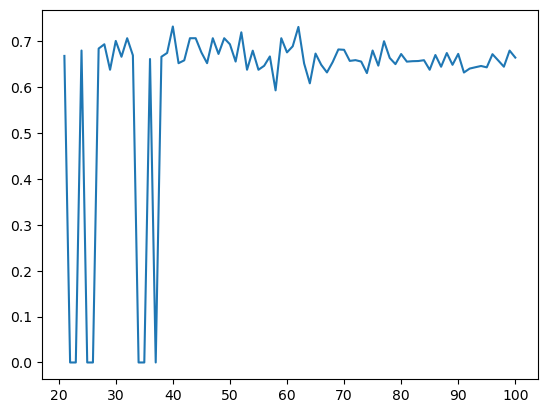

In [100]:
from torcheval.metrics import BinaryF1Score

def get_plot(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    metric_per_len = [BinaryF1Score() for i in range(21, 101)]
    #print(len(metric_per_len))
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")
            for i in range(X.shape[0]):
                sent_len = int(X[i].flatten().sum().item())
                metric_per_len[sent_len - 21].update(pred, y)

            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            


    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
    return metric_per_len

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metrics = get_plot(test_loader, model, loss_fn)

f1_scores = [metric.compute() for metric in metrics]
f1_scores

plt.plot(range(21, 101), f1_scores)


## Parameter sweep

In [12]:
sweep_config = {
    'method': 'random',
}

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'hidden_size': {
        'values': [3, 5, 10, 20]
    },
    'hidden_depth': {
        'values': [1, 2, 3]
    },
    'lr': {
        'values': [1e-2, 1e-3, 1e-4]
    },
    'num_epochs': {
        'values': [100, 200, 300]
    },
}

sweep_config['parameters'] = parameters_dict

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'hidden_depth': {'values': [1, 2, 3]},
                'hidden_size': {'values': [3, 5, 10, 20]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'num_epochs': {'values': [100, 200, 300]}}}


In [13]:
import wandb
sweep_id = wandb.sweep(sweep_config, project='lstm-sweep')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: azo0igm3
Sweep URL: https://wandb.ai/jarlku/lstm-sweep/sweeps/azo0igm3


In [14]:

def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
        
        model = LSTM(input_size, config.hidden_size, config.hidden_depth)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.BCELoss()
        

        for epoch in range(config.num_epochs):
            model.train()
            epoch_loss = 0

            for batch_idx, (inputs, targets) in enumerate(train_loader):
                #inputs = inputs.unsqueeze(-1)  # Add input_size dimension
                # Forward pass
                outputs = model(inputs)
                #print(outputs)
                loss = criterion(outputs, targets)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            wandb.log({'loss': epoch_loss / len(train_loader)})
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')
        
        metric = BinaryF1Score()
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            wandb.log({'val_loss': loss})
            metric.update(outputs, targets)
            wandb.log({'val_f1': metric.compute()})
            
            

wandb.agent(sweep_id, train, count=5)

In [15]:
wandb.agent(sweep_id, train_wandb, count=10)

wandb: Agent Starting Run: as1vowmx with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 5
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jarlsoeren (jarlku). Use `wandb login --relogin` to force relogin


Epoch [10/200], Loss: 0.6934
Epoch [20/200], Loss: 0.2405
Epoch [30/200], Loss: 0.2043
Epoch [40/200], Loss: 0.2157
Epoch [50/200], Loss: 0.1797
Epoch [60/200], Loss: 0.2603
Epoch [70/200], Loss: 0.1857
Epoch [80/200], Loss: 0.2588
Epoch [90/200], Loss: 0.2297
Epoch [100/200], Loss: 0.2273
Epoch [110/200], Loss: 0.2271
Epoch [120/200], Loss: 0.2544
Epoch [130/200], Loss: 0.2525
Epoch [140/200], Loss: 0.2316
Epoch [150/200], Loss: 0.2297
Epoch [160/200], Loss: 0.2581
Epoch [170/200], Loss: 0.2272
Epoch [180/200], Loss: 0.2268
Epoch [190/200], Loss: 0.2609
Epoch [200/200], Loss: 0.2294


loss,███▂▁▃▁▁▁▁▁▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_f1,█▅▁▅▅▄▃▃▅▆▇█▇█▇▇
val_loss,▄▅█▂▄▆▇▄▁▂▃▁▅▂█▄
loss,0.22936
val_f1,0.92421
val_loss,0.23335


wandb: Agent Starting Run: msgvj3ie with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 3
wandb: 	lr: 0.001
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.6912
Epoch [20/300], Loss: 0.6936
Epoch [30/300], Loss: 0.6927
Epoch [40/300], Loss: 0.5559
Epoch [50/300], Loss: 0.2685
Epoch [60/300], Loss: 0.2097
Epoch [70/300], Loss: 0.2281
Epoch [80/300], Loss: 0.1879
Epoch [90/300], Loss: 0.2207
Epoch [100/300], Loss: 0.1805
Epoch [110/300], Loss: 0.1763
Epoch [120/300], Loss: 0.1752
Epoch [130/300], Loss: 0.1713
Epoch [140/300], Loss: 0.2125
Epoch [150/300], Loss: 0.1822
Epoch [160/300], Loss: 0.1810
Epoch [170/300], Loss: 0.2600
Epoch [180/300], Loss: 0.2582
Epoch [190/300], Loss: 0.2857
Epoch [200/300], Loss: 0.2274
Epoch [210/300], Loss: 0.2542
Epoch [220/300], Loss: 0.2269
Epoch [230/300], Loss: 0.2202
Epoch [240/300], Loss: 0.2259
Epoch [250/300], Loss: 0.2241
Epoch [260/300], Loss: 0.2238
Epoch [270/300], Loss: 0.2076
Epoch [280/300], Loss: 0.2001
Epoch [290/300], Loss: 0.1619
Epoch [300/300], Loss: 0.2382


loss,█████▆▃▂▂▁▁▁▂▁▁▂▁▁▂▁▁▁▂▂▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁▂
val_f1,▁█▇▇▇██▇▇▇▇██▇██
val_loss,█▁▄▄▃▃▃▆▄▅▅▂▄▄▁▃
loss,0.23819
val_f1,0.93897
val_loss,0.17922


wandb: Agent Starting Run: kmzexcw2 with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 3
wandb: 	lr: 0.001
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.7029
Epoch [20/300], Loss: 0.6940
Epoch [30/300], Loss: 0.6934
Epoch [40/300], Loss: 0.6932
Epoch [50/300], Loss: 0.6931
Epoch [60/300], Loss: 0.3870
Epoch [70/300], Loss: 0.2567
Epoch [80/300], Loss: 0.2889
Epoch [90/300], Loss: 0.2188
Epoch [100/300], Loss: 0.2095
Epoch [110/300], Loss: 0.2137
Epoch [120/300], Loss: 0.2043
Epoch [130/300], Loss: 0.1994
Epoch [140/300], Loss: 0.1991
Epoch [150/300], Loss: 0.1993
Epoch [160/300], Loss: 0.2361
Epoch [170/300], Loss: 0.2960
Epoch [180/300], Loss: 0.2411
Epoch [190/300], Loss: 0.2415
Epoch [200/300], Loss: 0.2022
Epoch [210/300], Loss: 0.2001
Epoch [220/300], Loss: 0.1980
Epoch [230/300], Loss: 0.1947
Epoch [240/300], Loss: 0.1942
Epoch [250/300], Loss: 0.1919
Epoch [260/300], Loss: 0.2265
Epoch [270/300], Loss: 0.1980
Epoch [280/300], Loss: 0.1961
Epoch [290/300], Loss: 0.1921
Epoch [300/300], Loss: 0.2245


loss,███████▆▃▂▂▁▁▁▁▁▂▁▁▁▁▂▇▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁
val_f1,▇█▁▂▂▂▁▃▄▄▅▅▅▄▄▄
val_loss,▂▃█▂▆▃▅▁▁▂▁▄▂▇▄▃
loss,0.22445
val_f1,0.94518
val_loss,0.17353


wandb: Agent Starting Run: oh5ssg2r with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 20
wandb: 	lr: 0.001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.6934
Epoch [20/100], Loss: 0.6080
Epoch [30/100], Loss: 0.5894
Epoch [40/100], Loss: 0.6267
Epoch [50/100], Loss: 0.5989
Epoch [60/100], Loss: 0.6081
Epoch [70/100], Loss: 0.5936
Epoch [80/100], Loss: 0.5990
Epoch [90/100], Loss: 0.6002
Epoch [100/100], Loss: 0.5943


loss,▆▆▆▆▆▁█▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▄▄▄▄▄▄▄▅▄▄▄
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▆▂▃▂█▃▂▅▂▄▃▂▅▁▄
loss,0.5943
val_f1,0.0
val_loss,0.76798


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hljxwpqe with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 10
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.6952
Epoch [20/200], Loss: 0.6932
Epoch [30/200], Loss: 0.6933
Epoch [40/200], Loss: 0.6937
Epoch [50/200], Loss: 0.6934
Epoch [60/200], Loss: 0.6936
Epoch [70/200], Loss: 0.6931
Epoch [80/200], Loss: 0.3022
Epoch [90/200], Loss: 0.2015
Epoch [100/200], Loss: 0.1955
Epoch [110/200], Loss: 0.1772
Epoch [120/200], Loss: 0.1410
Epoch [130/200], Loss: 0.1227
Epoch [140/200], Loss: 0.1123
Epoch [150/200], Loss: 0.0954
Epoch [160/200], Loss: 0.0944
Epoch [170/200], Loss: 0.0624
Epoch [180/200], Loss: 0.0428
Epoch [190/200], Loss: 0.0550
Epoch [200/200], Loss: 0.0456


loss,███████████████▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁
val_f1,▅▃▅▃▁▃▅▅▆▇▆▇██▇▇
val_loss,▄▃▂▆▅▂▁▄▂▁▅▁▁▃▃█
loss,0.04555
val_f1,0.97847
val_loss,0.19299


wandb: Agent Starting Run: flr2ccq6 with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 3
wandb: 	lr: 0.001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.6932
Epoch [20/100], Loss: 0.6933
Epoch [30/100], Loss: 0.6929
Epoch [40/100], Loss: 0.6934
Epoch [50/100], Loss: 0.6931
Epoch [60/100], Loss: 0.6932
Epoch [70/100], Loss: 0.6933
Epoch [80/100], Loss: 0.6932
Epoch [90/100], Loss: 0.6931
Epoch [100/100], Loss: 0.6931


loss,█▅▁▃▂▂▂▂▁▂▂▂▂▂▁▂▂▂▃▂▂▂▂▂▂▂▂▂▃▁▆▂▂▂▃▂▂▂▂▂
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▁▂▂▂█▄▆█▁▃▄▃▃▅▂
loss,0.69312
val_f1,0.0
val_loss,0.69236


wandb: Agent Starting Run: 1t8bakg3 with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 3
wandb: 	lr: 0.0001
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.6937
Epoch [20/300], Loss: 0.6936
Epoch [30/300], Loss: 0.6928
Epoch [40/300], Loss: 0.6935
Epoch [50/300], Loss: 0.6941
Epoch [60/300], Loss: 0.6931
Epoch [70/300], Loss: 0.6935
Epoch [80/300], Loss: 0.6931
Epoch [90/300], Loss: 0.6926
Epoch [100/300], Loss: 0.6935
Epoch [110/300], Loss: 0.6931
Epoch [120/300], Loss: 0.6931
Epoch [130/300], Loss: 0.6929
Epoch [140/300], Loss: 0.6929
Epoch [150/300], Loss: 0.6929
Epoch [160/300], Loss: 0.6934
Epoch [170/300], Loss: 0.6929
Epoch [180/300], Loss: 0.6931
Epoch [190/300], Loss: 0.6933
Epoch [200/300], Loss: 0.6929
Epoch [210/300], Loss: 0.6932
Epoch [220/300], Loss: 0.6931
Epoch [230/300], Loss: 0.6930
Epoch [240/300], Loss: 0.6930
Epoch [250/300], Loss: 0.6931
Epoch [260/300], Loss: 0.6929
Epoch [270/300], Loss: 0.6924
Epoch [280/300], Loss: 0.6925
Epoch [290/300], Loss: 0.6915
Epoch [300/300], Loss: 0.6862


loss,█▇▇▇▇▇▆▇▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▅▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▆▂▅▇██▃▃▁▂▅▁▄▅▇
loss,0.68621
val_f1,0.0
val_loss,0.68876


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vvb9qu40 with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 20
wandb: 	lr: 0.001
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.6933
Epoch [20/300], Loss: 0.6940
Epoch [30/300], Loss: 0.2129
Epoch [40/300], Loss: 0.2356
Epoch [50/300], Loss: 0.3057
Epoch [60/300], Loss: 0.1951
Epoch [70/300], Loss: 0.1771
Epoch [80/300], Loss: 0.2398
Epoch [90/300], Loss: 0.2088
Epoch [100/300], Loss: 0.2393
Epoch [110/300], Loss: 0.2311
Epoch [120/300], Loss: 0.2290
Epoch [130/300], Loss: 0.2013
Epoch [140/300], Loss: 0.1933
Epoch [150/300], Loss: 0.2251
Epoch [160/300], Loss: 0.2077
Epoch [170/300], Loss: 0.2225
Epoch [180/300], Loss: 0.1876
Epoch [190/300], Loss: 0.2510
Epoch [200/300], Loss: 0.1662
Epoch [210/300], Loss: 0.1539
Epoch [220/300], Loss: 0.2089
Epoch [230/300], Loss: 0.2378
Epoch [240/300], Loss: 0.2355
Epoch [250/300], Loss: 0.2198
Epoch [260/300], Loss: 0.2156
Epoch [270/300], Loss: 0.2131
Epoch [280/300], Loss: 0.2486
Epoch [290/300], Loss: 0.2114
Epoch [300/300], Loss: 0.1963


loss,████▂▂▃▁▂▂▂▁▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▂▂▂▂▂▂▂▂▂▃▂▂
val_f1,█▅▃▃▄▃▃▃▂▂▂▁▁▁▁▁
val_loss,▁▅▇▄▂▆▅▅▆▆▆█▅▇▄▂
loss,0.19627
val_f1,0.93897
val_loss,0.11064


wandb: Agent Starting Run: 3d6z2a3p with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 20
wandb: 	lr: 0.0001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.6986
Epoch [20/100], Loss: 0.6939
Epoch [30/100], Loss: 0.6930
Epoch [40/100], Loss: 0.6931
Epoch [50/100], Loss: 0.6932
Epoch [60/100], Loss: 0.6926
Epoch [70/100], Loss: 0.6926
Epoch [80/100], Loss: 0.6918
Epoch [90/100], Loss: 0.4074
Epoch [100/100], Loss: 0.3101


loss,█████████████████████████████████▇▄▃▂▂▁▁
val_f1,▁▄▆▇▇▆█▇▇▆▆▄▅▅▆▆
val_loss,█▃▄▁▂▆▂▆▅▅▇█▄▂▆▁
loss,0.31008
val_f1,0.92851
val_loss,0.27106


wandb: Agent Starting Run: s4eb49mq with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 5
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.6863
Epoch [20/200], Loss: 0.3578
Epoch [30/200], Loss: 0.5462
Epoch [40/200], Loss: 0.2770
Epoch [50/200], Loss: 0.2932
Epoch [60/200], Loss: 0.2151
Epoch [70/200], Loss: 0.2119
Epoch [80/200], Loss: 0.1978
Epoch [90/200], Loss: 0.2245
Epoch [100/200], Loss: 0.2123
Epoch [110/200], Loss: 0.2498
Epoch [120/200], Loss: 0.2245
Epoch [130/200], Loss: 0.1622
Epoch [140/200], Loss: 0.1602
Epoch [150/200], Loss: 0.2643
Epoch [160/200], Loss: 0.1498
Epoch [170/200], Loss: 0.1458
Epoch [180/200], Loss: 0.1390
Epoch [190/200], Loss: 0.1660
Epoch [200/200], Loss: 0.1311


loss,██▇▅▄▃▅▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁
val_f1,▇█▃▄▄▅▃▃▃▂▂▁▁▂▂▃
val_loss,▄▁▇▃▄▃▇▄▄▆▃█▄▃▁▂
loss,0.13112
val_f1,0.94787
val_loss,0.10487
